In [1]:
# data generation of set of x,y points from a given pde


# import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn import linear_model as sk

In [8]:
# given a particular equation: y = x + error, generate data set pairs

# instantiate x
x = np.linspace(0, 100, 51)
y = x + np.random.normal(0, 0.1, size=(51,))


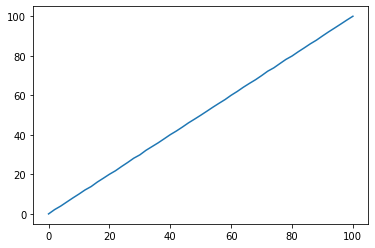

In [9]:
# visualize data via plot

plt.plot(x,y)

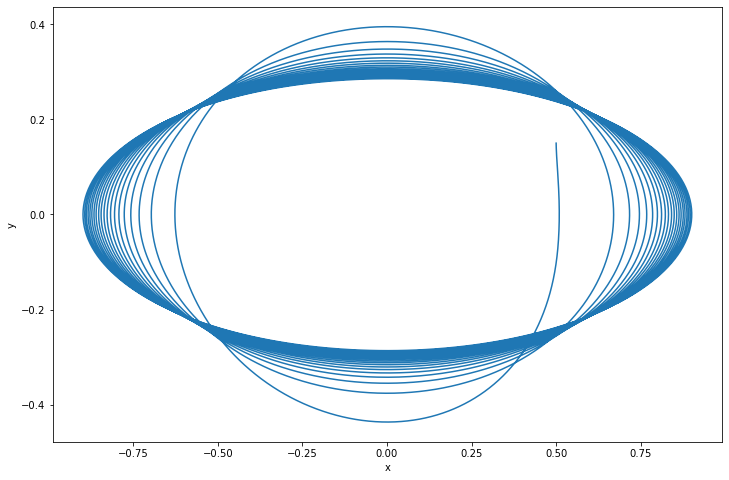

In [10]:
F = lambda t, s: np.dot(np.array([[0, t**2], [-t, 0]]), s)

t_eval = np.arange(0, 10, 0.001)
sol = solve_ivp(F, [0, 10], [0.5, 0.15], t_eval=t_eval)

plt.figure(figsize = (12, 8))
plt.plot(sol.y.T[:, 0], sol.y.T[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

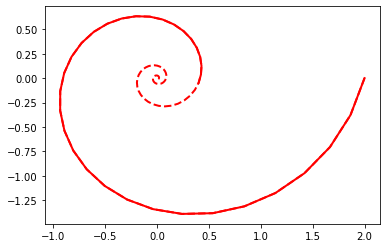

In [11]:
F = lambda t, s: np.dot(np.array([[-0.5, 2], [-2, -0.5]]), s)

t_eval = np.arange(0, 10, 0.1)
sol = solve_ivp(F, [0, 10], [2, 0], t_eval=t_eval)

fig, ax = plt.subplots()

ax.plot(sol.y.T[:100//3, 0], sol.y.T[:100//3, 1], 'r', linewidth=2)
ax.plot(sol.y.T[:, 0], sol.y.T[:, 1], 'r--', linewidth=2)


In [12]:
# implement lasso

clf = sk.Lasso(alpha=0.001) # alpha is regularization term

n = np.size(t_eval)
x, y = sol.y.T[:, 0], sol.y.T[:, 1] # t is t_eval
x = np.expand_dims(x, axis=1)
y = np.expand_dims(y, axis=1)

dxdt = np.gradient(sol.y.T[:, 0], t_eval) # dx/dt
dydt = np.gradient(sol.y.T[:, 1], t_eval) # dy/dt

In [13]:
# shuffle all data if desired
shuffler = np.random.permutation(n)
# make phi matrix 
phi = np.concatenate((np.ones((n,1)), x, y), axis=1) 
phi = phi
# make nu matrix, calculating derivatives dy/dt and dx/dt
nux = dxdt
nuy = dydt


# perform m trials of fitting, saving all coefficients
m = 100

coef = np.zeros((m, 2, 3)) # (trials, x or y, functional form)

for i in range(m):

    # add noise to nu matrix
    nux += np.random.normal(0, scale=0.1, size=np.size(nux))
    nuy += np.random.normal(0, scale=0.1, size=np.size(nuy))

    # only fit half of data

    clf.fit(phi[:n//3], nux[:n//3])
    coef[i, 0, :] = clf.coef_
    clf.fit(phi[:n//3], nuy[:n//3])
    coef[i, 1, :] = clf.coef_

    


In [14]:
coef[1, :, 1:]

array([[-0.56875848,  1.92815376],
       [-1.98412738, -0.47811673]])

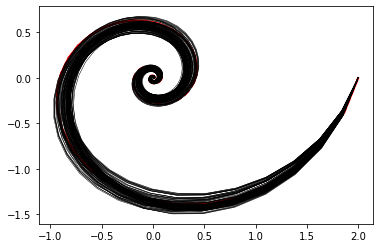

In [15]:
# plot the fitted data along with the actual numerical solution
for i in range(100): # plot all m trials
    coefi = coef[i, :, :]
    
    Fhat = lambda t, s: np.dot(coefi[:, 1:], s) + np.array(coefi[:, 0])

    t_eval = np.arange(0, 10, 0.1)
    sol = solve_ivp(Fhat, [0, 10], [2, 0], t_eval=t_eval)

    #plt.figure(figsize = (12, 8))
    ax.plot(sol.y.T[:, 0], sol.y.T[:, 1], 'k', linewidth=0.5)
fig

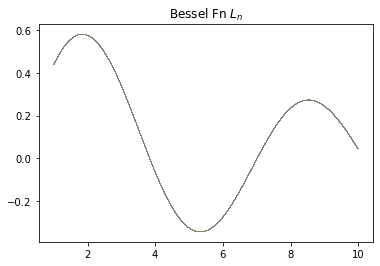

In [5]:
from scipy.special import jn

n = 1000
x = np.linspace(1, 10, n)
bn = 1 # bessel order number
tn = 100 # trials number

fig, ax = plt.subplots()

#ax.set_ylim(-2, 2)
ax.set_title(r'Bessel Fn $L_n$')

# plot 100 different measurements of the bessel function, with randomized gaussian noise

ymat = np.zeros((tn, np.size(x)))
for i in range(tn):
    y = jn(bn, x) #+ np.random.normal(0, 0.00001, size=np.shape(x))
    
    ymat[i] = y
    ax.plot(x, ymat[i], linewidth=0.1)

#y1 = jn(bn,x)
#y2 = jn(bn,x) * 4
#ax.plot(x, y1, label=rf'$L_{3}$')
#ax.plot(x, y2)
#ax.plot(x, y1+y2)
# y = y1 + y2 # sum up two solutions to test linearity
#y = y2
plt.show()



In [55]:
# feature matrix, calculating deriative terms

# order is dydx, d2ydx2, xdydx, xd2ydx2, x2dydx2, y, x2y
# fix x2y coefficient to 1, use as response variable in regression
featmat = np.zeros((tn, 7, np.size(x)))



for i in range(tn):
    yi = ymat[i]
    dydx = np.gradient(yi, x) # dy/dx
    d2ydx2 = np.gradient(dydx, x) # d2y/dx2
    xdydx = x * dydx
    xd2ydx2 = x * d2ydx2
    x2d2ydx2 = x * x * d2ydx2
    x2y = x * x * yi

    featmat[i, :, :] = np.array([dydx, d2ydx2, xdydx, xd2ydx2, x2d2ydx2, yi, x2y])




In [72]:


'''
# expand dims for concatenation, choose y to be the rhs
x = np.expand_dims(x, axis=1)
dydx = np.expand_dims(dydx, axis=1)
d2ydx2 = np.expand_dims(d2ydx2, axis=1)
xdydx = np.expand_dims(xdydx, axis=1)
xd2ydx2 = np.expand_dims(xd2ydx2, axis=1)
x2d2ydx2 = np.expand_dims(x2d2ydx2, axis=1)
#x2y = np.expand_dims(x2y, axis=1)
y = np.expand_dims(y, axis=1)
'''
cmat = np.zeros((tn, 6)) # coefficient least squares lasso for each trial
clf = sk.Lasso(alpha=0.1, max_iter=1e6)

y0 = [featmat[i, 5, 0], featmat[i, 0, 0]]

# add noise to nu matrix
# nux += np.random.normal(0, scale=0.1, size=np.size(nux))

# do lasso fitting
for i in range(tn):
    # make phi matrix 
    phi = featmat[i, :6, :].T # transpose since need observation number in row
    # make nu matrix, x2y output
    nux = featmat[i, 6, :]

    clf.fit(phi, nux)
    cmat[i,:] = clf.coef_

clf.score(phi, nux)



0.9997707777462689

In [75]:

# now exploit linearity of solution and pde and average the solutions
# sum over the first index and divide by tn

avgmat = np.sum(featmat, axis=0) / tn

# do lasso fitting

# make phi matrix 
phi = avgmat[:6, :].T # transpose since need observation number in row
# make nu matrix, x2y output
nux = avgmat[6, :]

clf.fit(phi, nux)
clf.coef_
#clf.score(phi, nux)


array([ 0.        , -0.        , -0.98754526, -0.13350885, -1.0082795 ,
        8.19891587])

In [68]:
# now try appended y all to a single trial instead of averaging




featmat = np.zeros((tn, 7, np.size(x)))



for i in range(tn):
    yi = ymat[i]
    dydx = np.gradient(yi, x) # dy/dx
    d2ydx2 = np.gradient(dydx, x) # d2y/dx2
    xdydx = x * dydx
    xd2ydx2 = x * d2ydx2
    x2d2ydx2 = x * x * d2ydx2
    x2y = x * x * yi

    featmat[i, :, :] = np.array([dydx, d2ydx2, xdydx, xd2ydx2, x2d2ydx2, yi, x2y])


# appended featmat

fmata = np.zeros((7, tn * np.size(x)))

for i in range(tn): # manually reshape to test
    fmata[:, i*np.size(x):(i+1)*np.size(x)] = featmat[i, :, :]
    



In [74]:

# do lasso fitting

# make phi matrix 
phi = fmata[:6, :].T # transpose since need observation number in row
# make nu matrix, x2y output
nux = fmata[6, :]


clf = sk.Lasso(alpha=4, max_iter=1e6)
clf.fit(phi, nux)
clf.coef_
#clf.score(phi, nux)

array([ 0.        , -0.        , -0.98754774, -0.11959755, -1.00819152,
        8.25745665])

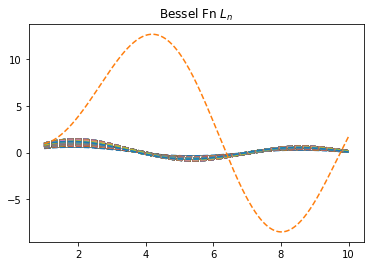

In [53]:
# reconstruct estimated pde solution

from scipy.integrate import odeint

def f(Y, x):
    nu = 3
    y = Y[0]
    z = Y[1]
  
    dydx = z
    dzdx = 1.0 / x**2 * (-x * z - (x**2 - nu**2) * y)
    return [dydx, dzdx]
    
x = np.linspace(1, 10, n)
#y0 = y0
us = odeint(f, y0, x)
ys = us[:,0] # y is first index of solution


ax.plot(x, ys, '--')
fig

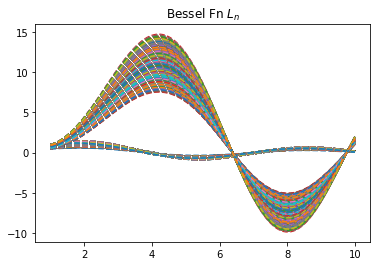

In [70]:
# construct different solutions from different initial conditions, then fit

tn = 100
x = np.linspace(1, 10, n)
ymat = np.zeros((tn, np.size(x)))
# matrix of initial conditions (tn, 2), (y0, y'0)
y0 = np.random.uniform(low=0.5, high=1.0, size=(tn, 2))

for i in range(tn):
    #y0 = y0
    us = odeint(f, y0[i], x)
    ymat[i] = us[:,0] # y is first index of solution
    ax.plot(x, ymat[i], '--')
fig     


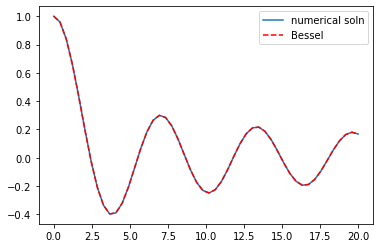

In [146]:
def fbessel(Y, x):
    nu = 0
    y = Y[0]
    z = Y[1]
  
    dydx = z
    dzdx = 1.0 / x**2 * (-x * z - (x**2 - nu**2) * y)
    return [dydx, dzdx]

x0 = 1e-15
y0 = 1
z0 = 0
Y0 = [y0, z0]

xspan = np.linspace(x0, 20)
sol = odeint(fbessel, Y0, xspan)

plt.plot(xspan, sol[:,0], label='numerical soln')
plt.plot(xspan, jn(0, xspan), 'r--', label='Bessel')
plt.legend()

In [79]:
# test for collinearity between features

obs = np.array([[1,2,3], [1,2,2]])

cor = np.corrcoef(fmata)